In [133]:
import ast
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from common import Fonts, Images, add_twitter_handle

In [126]:
year = "2023"
df = pd.read_csv(
    "data/goals_" + year + ".csv"
)
df["score_progression"] = df["score_progression"].apply(lambda x: ast.literal_eval(x))

df

,home,away,score_progression
0,NZL,NOR,"[(0, [0, 0]), (48, [1, 0])]"
1,AUS,IRL,"[(0, [0, 0]), (52, [1, 0])]"
2,NGA,CAN,"[(0, [0, 0])]"
3,PHI,SUI,"[(0, [0, 0]), (45, [0, 1]), (64, [0, 2])]"
4,ESP,CRC,"[(0, [0, 0]), (21, [1, 0]), (23, [2, 0]), (27,..."
5,USA,VIE,"[(0, [0, 0]), (14, [1, 0]), (45, [2, 0]), (77,..."
6,ZAM,JPN,"[(0, [0, 0]), (43, [0, 1]), (55, [0, 2]), (62,..."
7,ENG,HAI,"[(0, [0, 0]), (29, [1, 0])]"
8,DEN,CHN,"[(0, [0, 0]), (90, [1, 0])]"
9,SWE,RSA,"[(0, [0, 0]), (48, [0, 1]), (65, [1, 1]), (90,..."


In [127]:
def winner_first(scores):
    if scores[-1][1][0] >= scores[-1][1][1]:
        return scores
    else:
        return list(map(lambda x: (x[0], [x[1][1], x[1][0]]), scores))
    

df["score_progression"] = df["score_progression"].apply(winner_first)
df

,home,away,score_progression
0,NZL,NOR,"[(0, [0, 0]), (48, [1, 0])]"
1,AUS,IRL,"[(0, [0, 0]), (52, [1, 0])]"
2,NGA,CAN,"[(0, [0, 0])]"
3,PHI,SUI,"[(0, [0, 0]), (45, [1, 0]), (64, [2, 0])]"
4,ESP,CRC,"[(0, [0, 0]), (21, [1, 0]), (23, [2, 0]), (27,..."
5,USA,VIE,"[(0, [0, 0]), (14, [1, 0]), (45, [2, 0]), (77,..."
6,ZAM,JPN,"[(0, [0, 0]), (43, [1, 0]), (55, [2, 0]), (62,..."
7,ENG,HAI,"[(0, [0, 0]), (29, [1, 0])]"
8,DEN,CHN,"[(0, [0, 0]), (90, [1, 0])]"
9,SWE,RSA,"[(0, [0, 0]), (48, [0, 1]), (65, [1, 1]), (90,..."


In [128]:
# Sort progressions by end of game goal differential
def compare(p):
    if len(p) == 1:
        return 0
    else:
        return p[1][1][1] - p[1][1][0]
progression = sorted(list(df["score_progression"]), key=compare)  

In [129]:
# Pre-calculate the number of paths going through each node. In 
# this example the first index is the index of the goal and the
# second index is the goal differential.
counts = defaultdict(lambda: defaultdict(int))
for game in progression:
    i = 0
    for minute, goal in game:
        counts[i][goal[1] - goal[0]] += 1
        i+=1
        
counts

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {0: 21}),
             1: defaultdict(int, {-1: 16, 1: 2}),
             2: defaultdict(int, {-2: 9, 0: 2}),
             3: defaultdict(int, {-3: 6, -1: 2}),
             4: defaultdict(int, {-4: 4}),
             5: defaultdict(int, {-5: 3}),
             6: defaultdict(int, {-6: 1})})

In [130]:
# The number of points to extrapolate
n = 80

# Turn the lines defined by single points into lines with lots of points
def calc_points(xs, ys, cs):
    y_points = []
    x_points = []
    c_points = []
    i = 0
    for y in np.linspace(ys[0], ys[-1], n):
        # If this point lines up exactly with an original y, take the original x
        if y == ys[i]:
            y_points.append(y)
            x_points.append(xs[i])
            c_points.append(cs[i])
            continue

        # If this point has passed the next y, increment i
        if y > ys[i + 1]:
            i += 1

        # Extrapolate x between the ys
        if xs[i] == xs[i + 1]:
            ratio = (y - ys[i]) / (ys[i + 1] - ys[i])
            y_points.append(y)
            x_points.append(xs[i] + ratio * (xs[i + 1] - xs[i]))
            c_points.append(cs[i] + ratio * (cs[i + 1] - cs[i]))

    return (x_points, y_points, c_points)

<Figure size 720x864 with 0 Axes>

<Figure size 12000x14400 with 0 Axes>

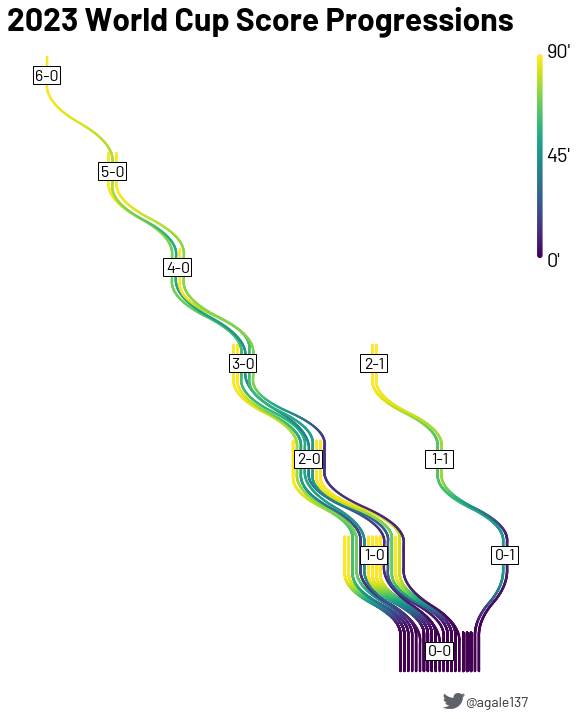

In [136]:
# General
plt.clf()
plt.rcParams["figure.figsize"] = (10, 12)
plt.figure(dpi=1200, facecolor="white")
fig, ax = plt.subplots()
fig.patch.set_facecolor("white")

# Plot lines
drawn = defaultdict(lambda: defaultdict(int))

ymax = 0
xmax = 0
xmin = 0

for i, game in enumerate(progression):
    x = []
    y = []
    c = []
    for minute, goal in game:
        new_x = goal[1] - goal[0]
        new_y = int(y[-1] + 0.8) if len(y) > 0 else 0

        lines_at_node = counts.get(new_y).get(new_x)
        lines_drawn = drawn[new_y][new_x]

        # Adjust to spread out lines at each node
        adjusted_x = new_x + (lines_drawn - lines_at_node / 2 + 0.5) * 0.06

        # Add two points so the line is straight when going through the node
        c.append(minute)
        x.append(adjusted_x)
        y.append(new_y - 0.2)
        c.append(minute)
        x.append(adjusted_x)
        y.append(new_y + 0.2)

        drawn[new_y][new_x] += 1

    # Convert from sparse x, y to interpolated points to add color
    x_points, y_points, c_points = calc_points(x, y, c)

    f = interp1d(y_points, x_points, kind="quadratic")
    y2 = np.linspace(y_points[0], y_points[-1], num=1000)
    x2 = f(y2)

    f2 = interp1d(y_points, c_points, kind="cubic")
    c2 = f2(y2)

    plt.scatter(
        x2,
        y2,
        s=2,
        c=c2,
        cmap="viridis",
    )

    ymax = max(ymax, y2[-1])
    xmax = max(xmax, max(x2))
    xmin = min(xmin, min(x2))

    # Add score labels

    # Constants for rendering labels
    w = (xmax - xmin) * 0.06
    h = ymax * 0.03
    x_off = -0.01
    y_off = 0.01

    # Format the score based on the x and y coordinate
    def format_scores(x_coord, y_coord):
        if x_coord == 0:
            return str(int(y_coord / 2)) + "-" + str(int(y_coord / 2))
        elif x_coord < 0:
            shared = y_coord + x_coord
            return str(int(shared / 2 - x_coord)) + "-" + str(int(shared / 2))
        else:
            shared = y_coord - x_coord
            return str(int(shared / 2)) + "-" + str(int(shared / 2 + x_coord))


# Iterate over all nodes that have lines through them to add labels
for y_node in counts.keys():
    for x_node in counts[y_node].keys():
        ax.text(
            x_node,
            y_node,
            format_scores(x_node, y_node),
            color="black",
            fontsize=16,
            fontproperties=Fonts.BARLOW,
            fontweight="bold",
            va="center",
            ha="center",
        )

        rect = patches.Rectangle(
            (x_node - w / 2 + x_off, y_node - h / 2 + y_off),
            w,
            h,
            linewidth=1,
            edgecolor="black",
            facecolor="white",
            zorder=2,
        )
        # add rectangle to plot
        ax.add_patch(rect)

# Legend
n_leg = 100
x_scat = np.repeat(xmax + 0.5, n_leg)
y_scat = np.linspace(ymax * 2 / 3, ymax, n_leg)
c_scat = np.linspace(0, 90, n_leg)

plt.scatter(
    x_scat,
    y_scat,
    s=20,
    c=c_scat,
    cmap="viridis",
)

ax.text(
    xmax + 0.5 + 0.1,
    ymax * 2 / 3 + 0.03,  # Small adjustment to align the 0'
    "0'",
    color="black",
    fontsize=20,
    fontproperties=Fonts.BARLOW,
    va="top",
    ha="left",
)
ax.text(
    xmax + 0.5 + 0.1,
    ymax * 5 / 6,
    "45'",
    color="black",
    fontsize=20,
    fontproperties=Fonts.BARLOW,
    va="center",
    ha="left",
)
ax.text(
    xmax + 0.5 + 0.1,
    ymax,
    "90'",
    color="black",
    fontsize=20,
    fontproperties=Fonts.BARLOW,
    va="baseline",
    ha="left",
)

# Title
plt.title(
    year + " World Cup Score Progressions",
    fontproperties=Fonts.BARLOW_BOLD,
    size=32,
    x=0,
    ha="left",
)

# Axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim([y2[0] - 0.2, ymax + 0.2])

# Twitter logo and username
add_twitter_handle(fig, x=0.73, y=0.1, fs=14, w=0.025)

# Save image
plt.savefig(
    "images/score_progression_" + year + ".png", bbox_inches="tight", pad_inches=0.5
)